# 순환 신경망 (RNN)

## 5.1 확률과 언어 모델
### 5.1.1 word2vec을 확률 관점에서 바라보다
CBOW 모델의 본래 목적은 맥락으로부터 타깃을 추측하는 것. 이 목적을 위해 학습을 진행하면 '단어의 분산 표현'을 얻을 수 있음. 이는 어디에 쓰일 수 있을까? 
### 5.1.2 언어 모델
언어 모델에 쓰인다.언어 모델은 단어 나열에 확률을 부여한다.
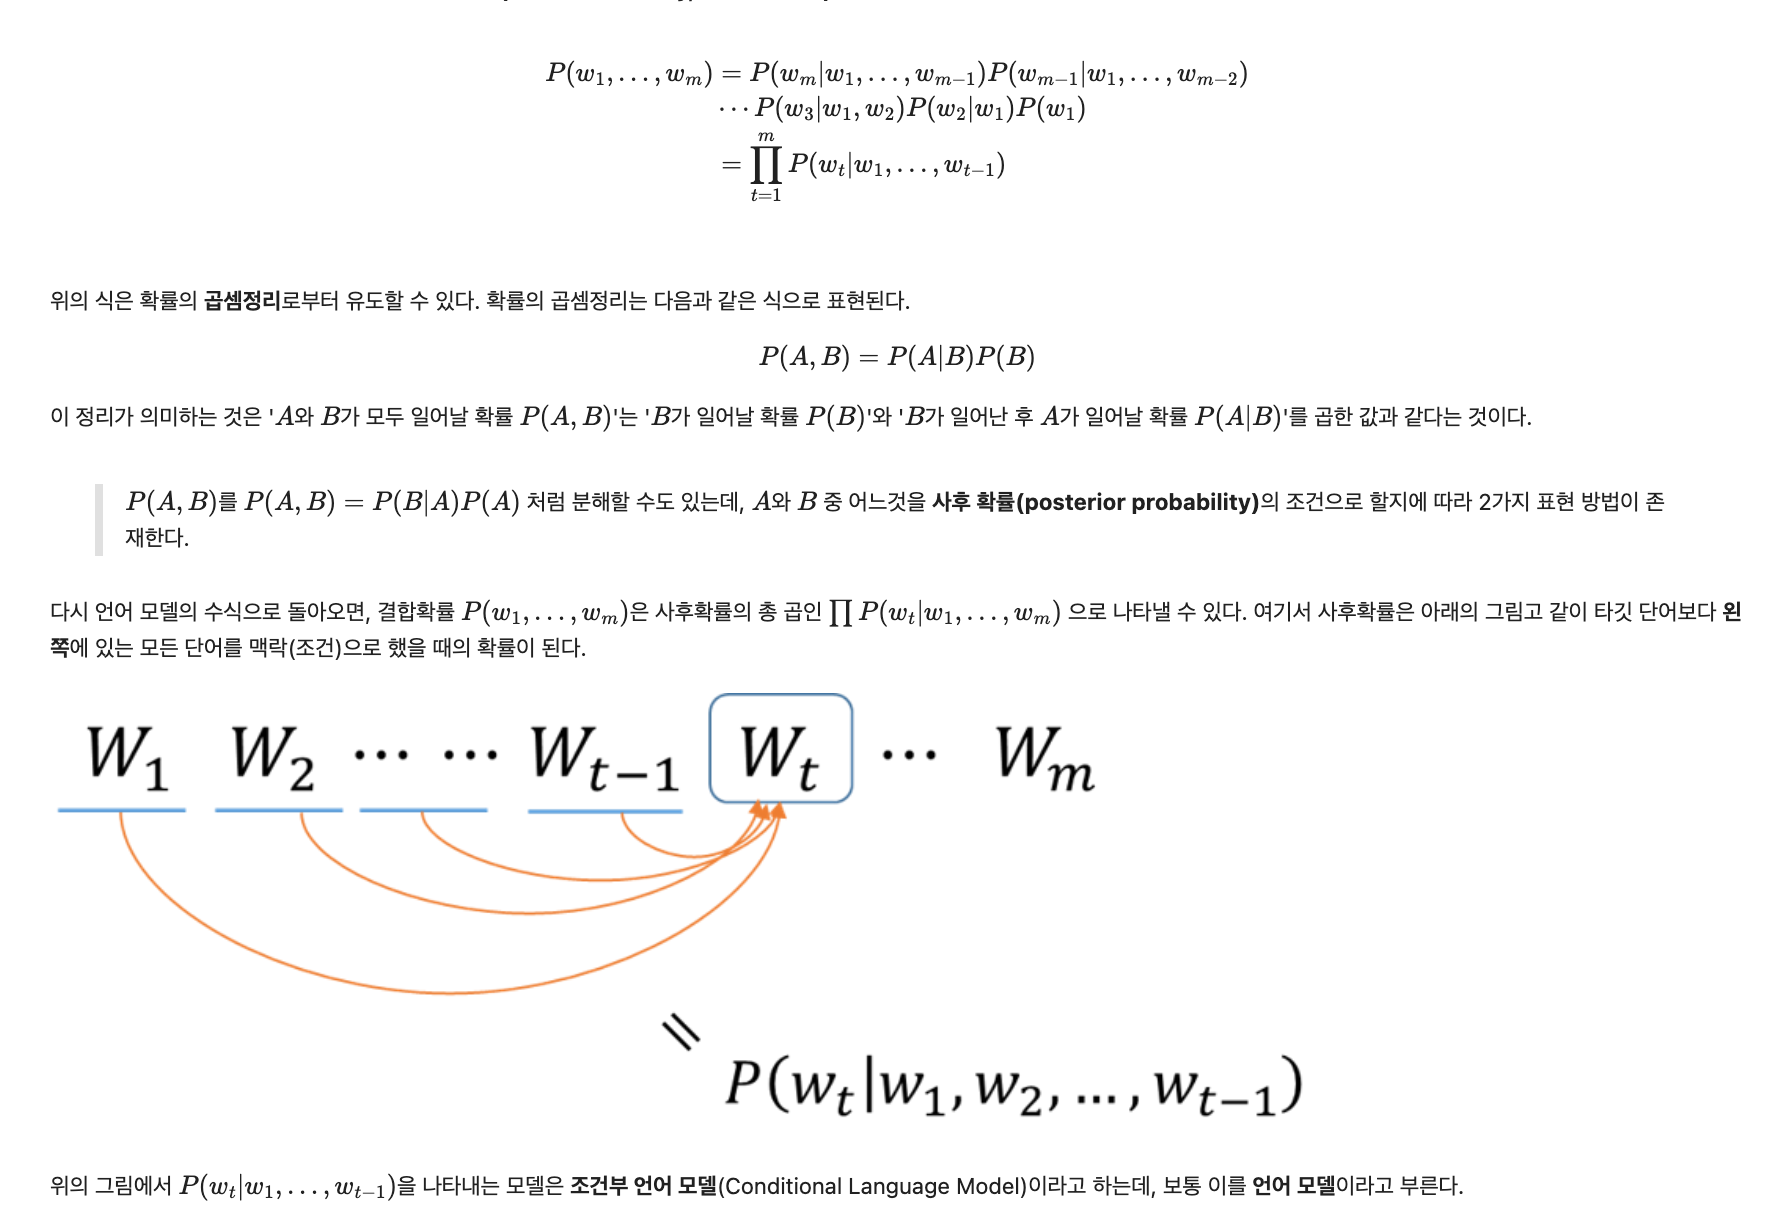

### 5.1.3 word2vec을 언어 모델로?
- 맥락의 길이가 특정 길이로 고정 된다.
- 고려해야할 맥락이 11번째 전인데, 맥락의 고정 길이는 10이라면, 제대로 읽어낼 수 ㅓㅂㅅ다.
    - 맥락 크기를 20,30으로 키우면?
- But, CBOW는 맥락 안의 단어 순서를 고려하지 않는다.

## 5.2 RNN 이란?

'Recurrent'란 몇 번이나 반복해서 일어나는 일. 순환한다. 라는 의미를 가지고 있다. 
## 5.2.1 순환하는 신경망
순환하기 위해서는 닫힌 경로가 필요하다. '단힌 경로'가 존재해야 데이터가 같은 장소를 반복해 왕래할 수 있다. 그리고 데이터가 순환하면서 정보다 끊임없이 갱신되게 된다.  
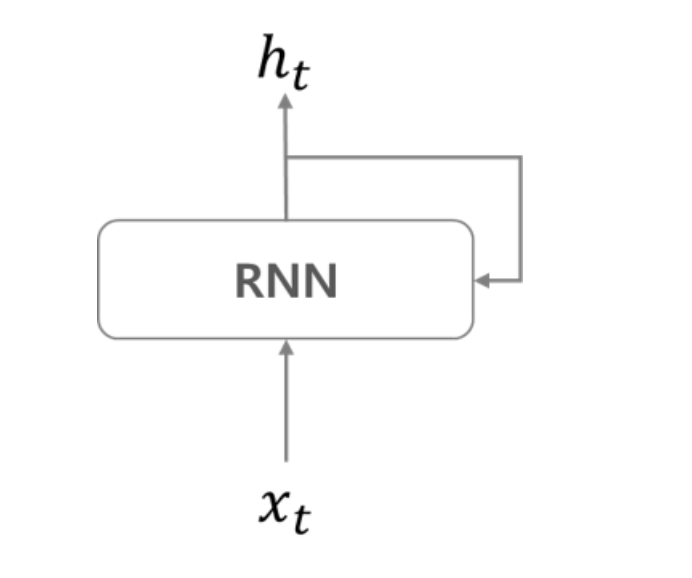

### 5.2.2 순환 구조 펼치기
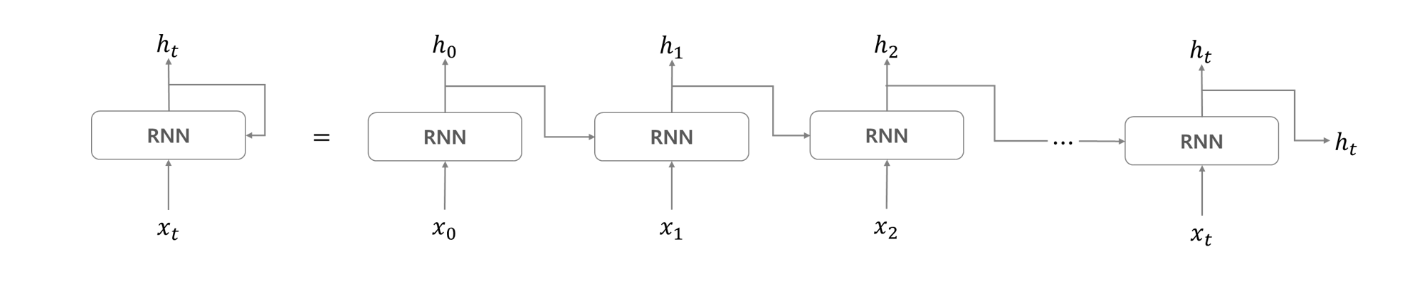
각 시각의 RNN 계층은 그 계층으로의 입력과 1개 전의 RNN 계층으로부터의 출력을 받는다. 그리고 이 두 정보를 바탕으로 현 시각의 출력을 계산한다.  
현재의 출력 (ht)는 한 시각 이전 출력 (ht-1)에 기초해 계산됨을 알 수 있다. 따라서 RNN은 '상태'를 가지고 있기 때문에 RNN 계층을 '상태를 가지는 층' 혹은 '메모리가 있는 계층'이라고 한다.   
- 또한 RNN의 출려 ht를 '은닉 상태' 혹은 '은닉 상태 벡터'라고 한다.

### 5.2.3 BPTT : backpropagation through time
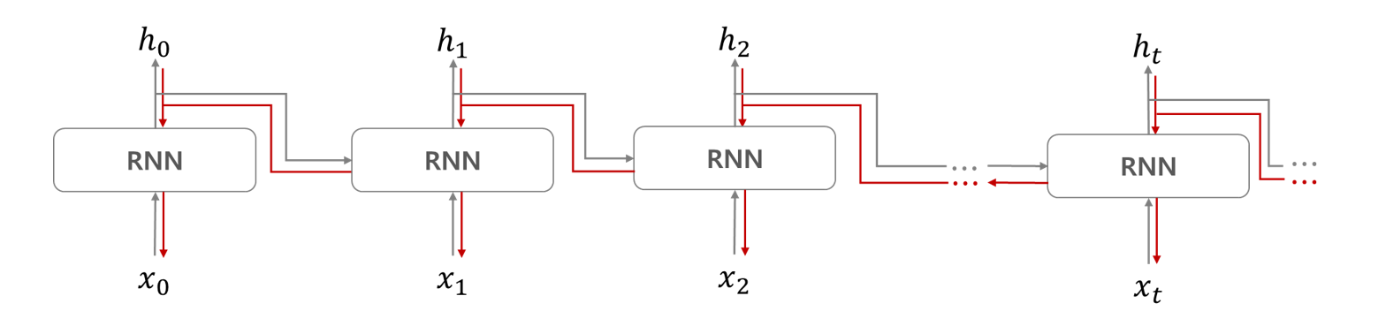
- BPTT : 시간 방향으로 펼친 신경망의 오차역전파법
- 문제 : 긴 시계열 데이터를 학습할때 문제 (시계열 데이터가 길어짐에 따라 계산량과 메모리 사용량이 증가한다.)

### 5.2.4 Truncated BPTT
- 큰 시계열 데이터를 취급할때는 신경망 연결을 적당한 길이로 '끊는다'.
- 시간축 방향으로 너무 긴 신경망을 적당한 지점에서 잘라내어 작은 신경망 여러개로 만든다는 아이디어이다.
- 잘라낸 작은 신경망에서 오차역전파법을 수행한다. 
- 이것이 **Truncated BPTT**  
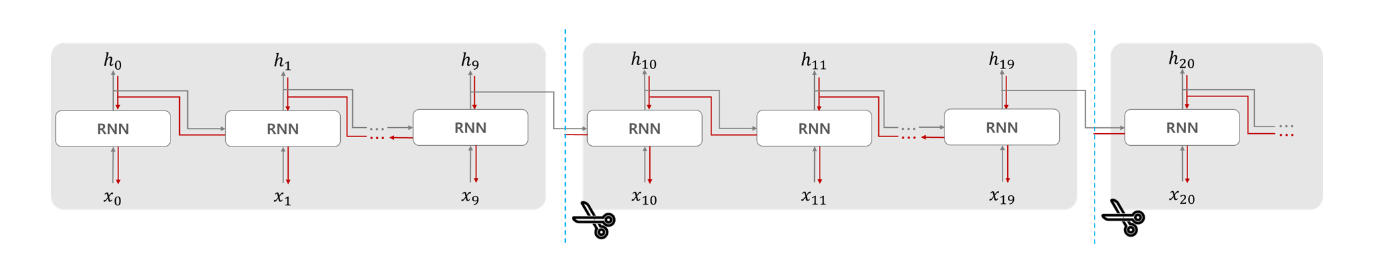
위 그림에서 알 수 있듯이 순전파의 연결은 끊어지지 않는다. RNN을 학습시킬때는 데이터를 순서대로 입력해야 한다.

### 5.2.5 Truncated BPTT의 미니배치 학습
위에서 살표본 학습처리순서는 미니배치를 고려하지 않은, 미니배치가 1일 때에 해당하는 학습 방법이다. 미니배치 수가 2 이상인 배치를 학습하기 위해서는 시작위치를 각 미니배치의 시작위치로 **'옮겨줘야'** 한다.  
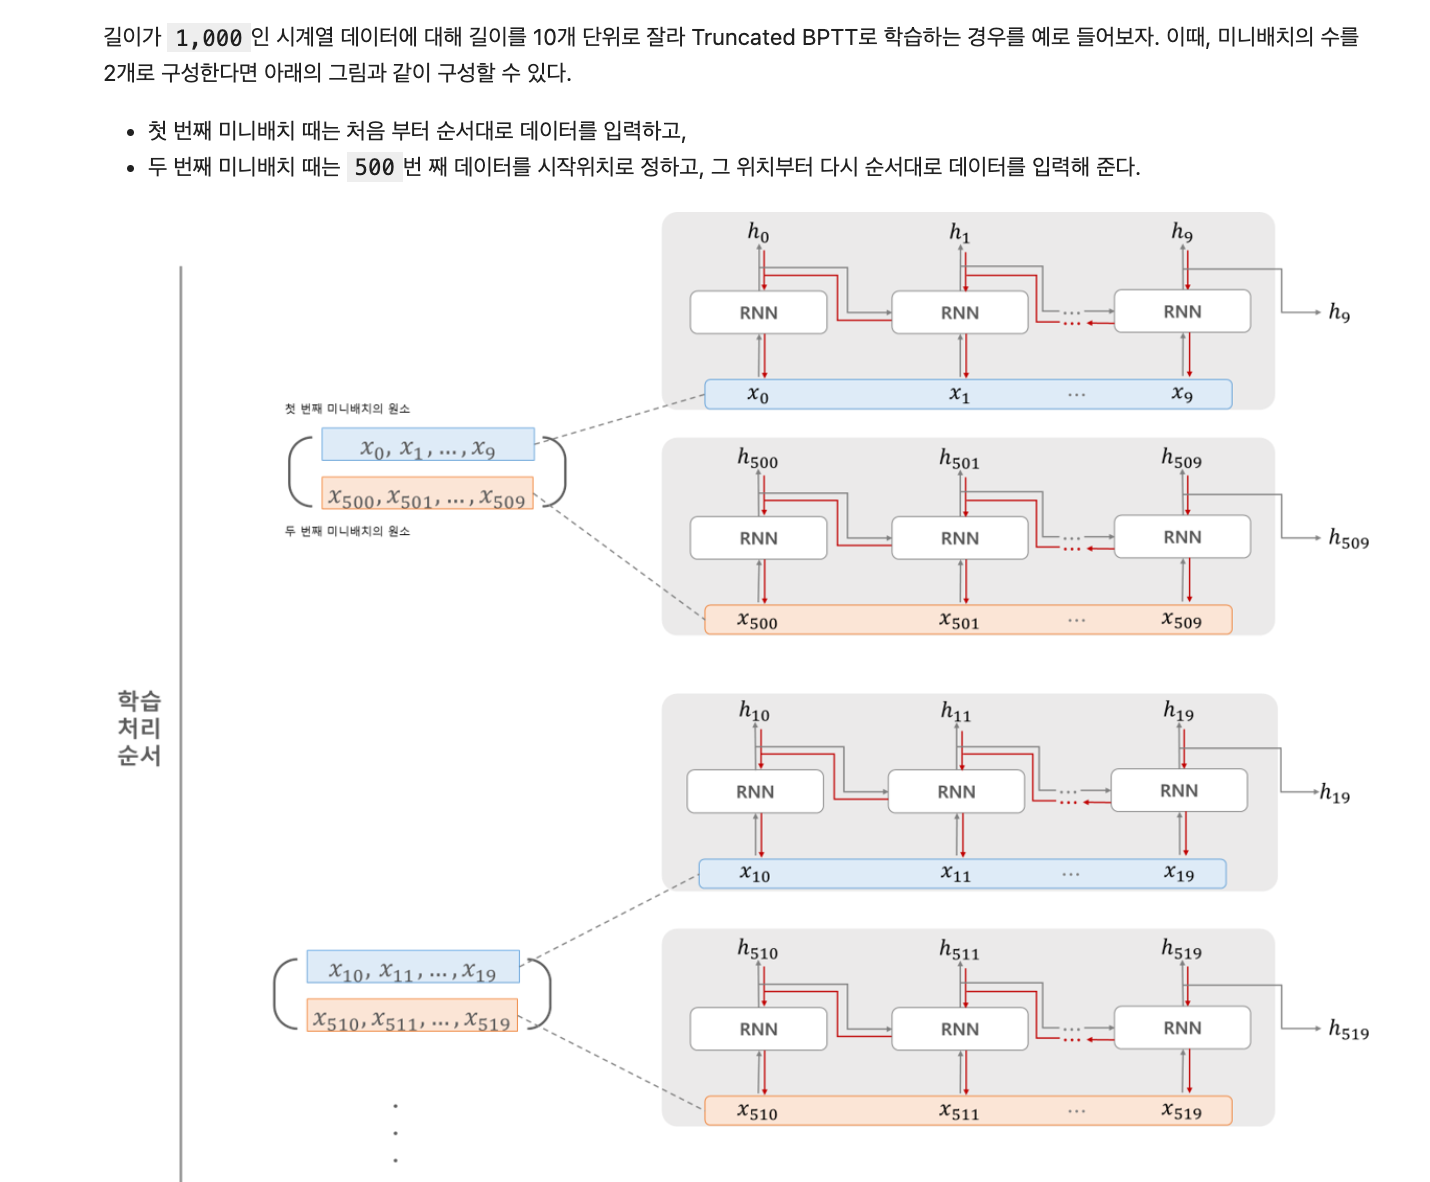

## 5.3 RNN 구현
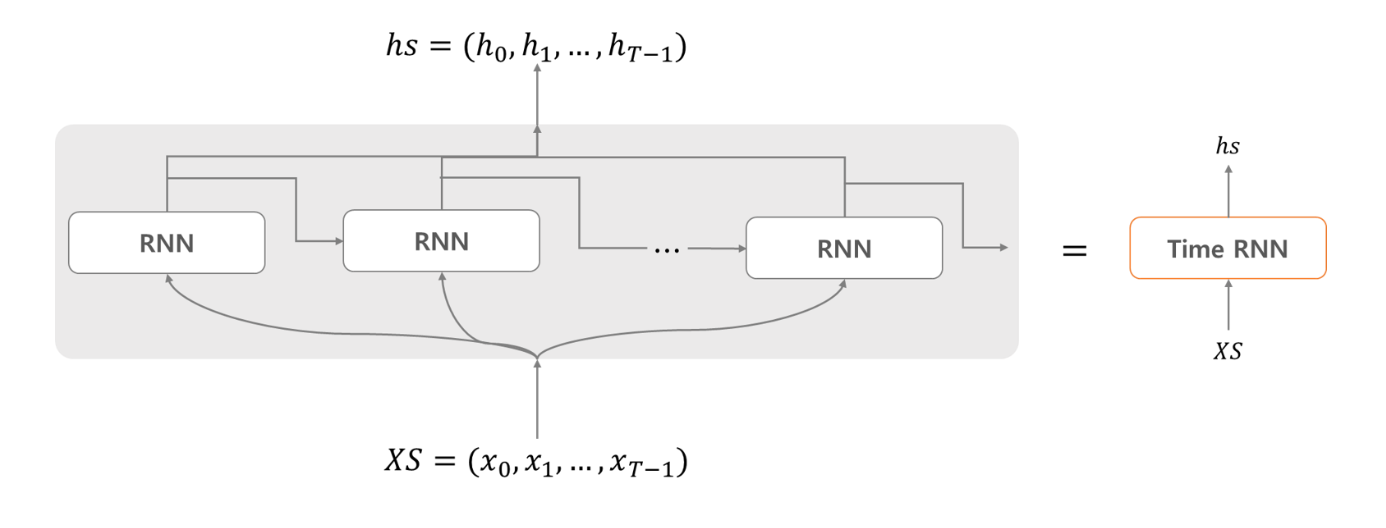
> Time RNN과 같이 시계열 데이터를 한꺼번에 처리하는 계층에는 앞에 'Time'을 붙인다.

### 5.3.1 RNN 계층 구현
> 항상 형상 확인이 가장 중요하니 실행하기 전에는 형상 확인을 수행해주어야 함.

In [4]:
#RNN 클래스의 초기화와 순전파 메서드
class RNN:
    def __init__(self,Wx,Wh,b):
        self.params=[Wx,Wh,b]
        self.grads=[np.zeros_like(Wx),np.zeros_like(Wh),np.zeros_like(b)]
        self.cache=None #역전파 계산 시 사용하는 중간 데이터를 담을 cache를 none으로 초기화
    
    #순전파
    def forward(self,x,h_prev): #아래로부터 입력 x와 왼쪽으로부터의 입력 h_prev을 받음
        Wx,Wh,b=self.params
        t= np.matmul(h_prev,Wh)+np.matmul(x,Wx)+b
        h_next=np.tanh(t)
        
        self.cache = (x,h_prev,h_next)
        return h_next
    
    def backward(self,dh_next):
        Wx,Wh,b=self.params
        x,h_prev, h_next = self.cache
        
        dt=dh_next*(1-h_next**2)
        db=np.sum(dt,axis=0)
        dWh = np.dot(h_prev.T, dt)  # shape: (H, N) x (N, H) = (H, H)
        dh_prev = np.dot(dt, Wh.T)  # shape: (N, H) x (H, H) = (N, H)
        dWx = np.dot(x.T, dt)  # shape: (D, N) x (N, H) = (D, H)
        dx = np.dot(dt, Wx.T)  # shape: (N, H) x (H, D) = (N, D)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev

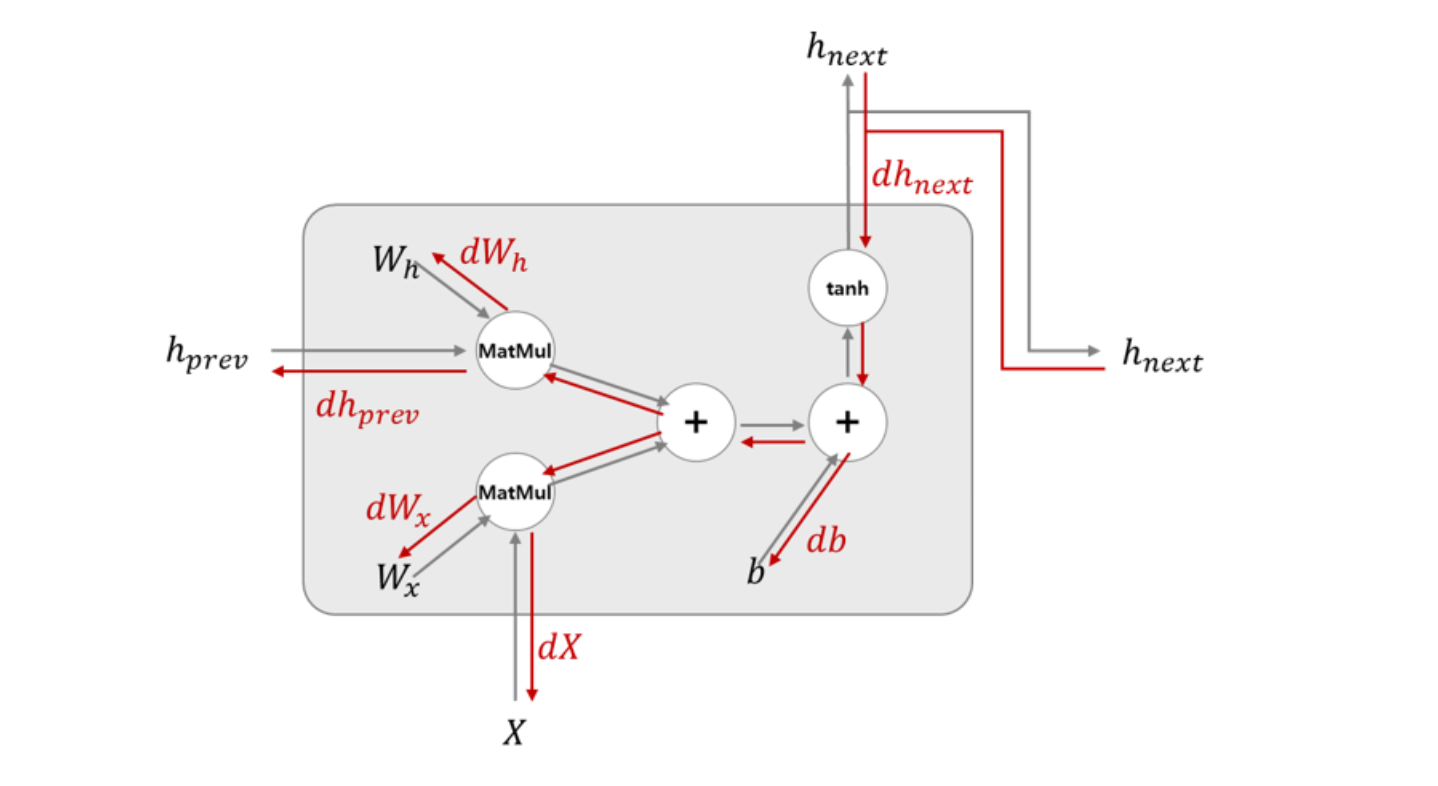

### 5.3.2 Time RNN 계층 구현
Time RNN 계층은 T개의 RNN 계층으로 구성된다.  
여기에서는 RNN 계층의 은닉 상태 h를 인스턴스 변수로 유지한다. 이 변수는 은닉 상태를 인계받는 용도로 사용한다.
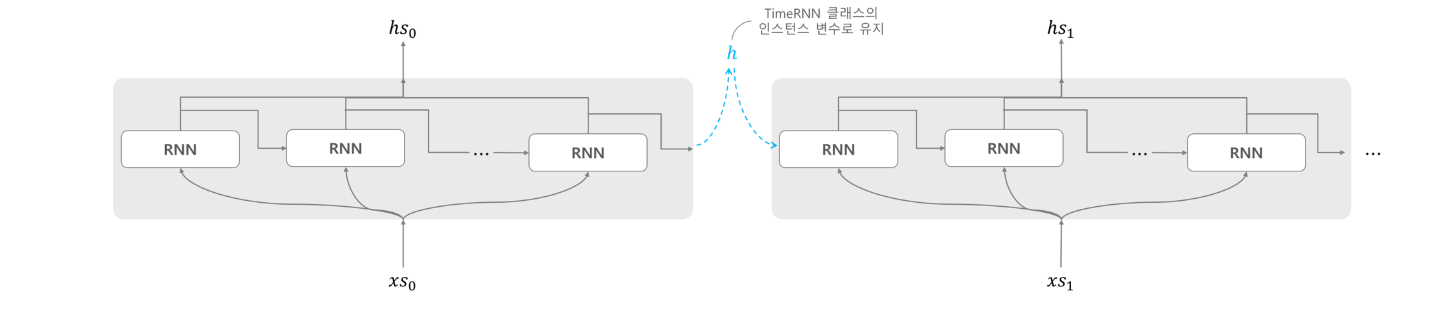
이렇게 하면 Time RNN 사용자는 RNN 계층 사이에서 은닉 상태를 '인계하는 작업'을 생각하지 않아도 된다는 장점이 생긴다.

hidden state **h**를 전달 받을지를 `stateful`이라는 인수로 조정할 수 있도록 구현한다.  
- stateful이라는 인수가 true일 경우 h를 유지한다는 뜻이다. 즉, 아무리 긴 시계열 데이터라도 TimeRNN 계층의 순전파를 끊지 않고 전파한다는 의미이다.
- false인 경우, **h**는 영행렬(무상태) 로 초기화한다.

In [6]:
# Time RNN 계층의 코드
# common/time_layers.py
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None  # RNN 계층을 리스트로 저장
        
        self.h, self.dh = None, None
        self.stateful = stateful
        
    def set_state(self, h):
        '''hidden state(h)를 설정하는 메서드'''
        self.h = h
    
    def reset_state(self):
        '''hidden state(h)를 초기화하는 메서드'''
        self.h = None
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape  # N(batch), T(time steps), D(input size)
        D, H = Wx.shape
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
            
        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)
            
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape
        
        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)  # 합산된 기울기
            dxs[:, t, :] = dx
            
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
                
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        
        return dxs

## 5.4 시계열 데이터 처리 계층 구현 
5장의 목표는 RNN을 사용하여 '언어 모델'을 만드는 것이다. 이번 절에서는 TimeRNN을 이용하여 **RNN Language Model**을 만들어본다.